In [10]:

import numpy as np
import pandas as pd
from scipy.stats import norm, ttest_ind
from tqdm import tqdm
from matplotlib import pyplot as plt

# Напишем функцию t-теста с применением дельтаметода

In [2]:
def deltamethod(x_0, y_0, x_1, y_1):
    n_0 = y_0.shape[0]
    n_1 = y_0.shape[0]

    mean_x_0, var_x_0 = np.mean(x_0), np.var(x_0)
    mean_x_1, var_x_1 = np.mean(x_1), np.var(x_1)

    mean_y_0, var_y_0 = np.mean(y_0), np.var(y_0)
    mean_y_1, var_y_1 = np.mean(y_1), np.var(y_1)

    cov_0 = np.mean((x_0 - mean_x_0.reshape(-1, )) * (y_0 - mean_y_0.reshape(-1, )))
    cov_1 = np.mean((x_1 - mean_x_1.reshape(-1, )) * (y_1 - mean_y_1.reshape(-1, )))

    var_0 = var_x_0 / mean_y_0 ** 2 + var_y_0 * mean_x_0 ** 2 / mean_y_0 ** 4 - 2 * mean_x_0 / mean_y_0 ** 3 * cov_0
    var_1 = var_x_1 / mean_y_1 ** 2 + var_y_1 * mean_x_1 ** 2 / mean_y_1 ** 4 - 2 * mean_x_1 / mean_y_1 ** 3 * cov_1

    rto_0 = np.sum(x_0) / np.sum(y_0)
    rto_1 = np.sum(x_1) / np.sum(y_1)

    statistic = (rto_1 - rto_0) / np.sqrt(var_0 / n_0 + var_1 / n_1)
    pvalue = 2 * np.minimum(norm(0, 1).cdf(statistic), 1 - norm(0, 1).cdf(statistic))
    return pvalue

### Будем пробовать на тестовых данных
В качестве примера сгенерим выручку. В знаменатель у нас пойдет единичка. Метрикой для симуляций выступит ARPU = Revenue / Users

In [4]:
np.random.seed(3)
n = 1000

df = pd.DataFrame({
    'user_cnt': 1,
    'revenue_amt': np.random.exponential(100, size=n),
    'variant': np.random.randint(low = 0, high = 2, size = n)
})

display(df)

,user_cnt,revenue_amt,variant
0,1,80.028239,1
1,1,123.150785,1
2,1,34.376540,0
3,1,71.504031,1
4,1,223.443081,1
...,...,...,...
995,1,27.512164,0
996,1,86.769554,1
997,1,46.314428,0
998,1,3.579858,0


### Теперь сравним pvalue с применением дельтаметода и без

In [6]:
deltamethod(
    df.revenue_amt[df.variant == 0],
    df.user_cnt[df.variant == 0],
    df.revenue_amt[df.variant == 1],
    df.user_cnt[df.variant == 1]
)

0.02011877470020096

In [7]:
ttest_ind(df.revenue_amt[df.variant == 0], df.revenue_amt[df.variant == 1])

Ttest_indResult(statistic=-2.3388164140624577, pvalue=0.0195415202760658)

### Напоследок симулируем 1000 A/A тестов
Ожидаем, что оба теста должны показывать одинаковые pvalue

In [8]:
n = 1000

pvalues_dm = []
pvalues_t = []
np.random.seed(4)
for _ in tqdm(range(0,1000)):
    sim = pd.DataFrame({
        'user_cnt': 1,
        'revenue_amt': np.random.exponential(100, size=n),
        'variant': np.random.randint(low = 0, high = 2, size = n)
    })
    sim['variant'] = np.random.randint(0,2,len(sim))

    pvalues_dm.append(deltamethod(
        sim.revenue_amt[sim.variant == 0],
        sim.user_cnt[sim.variant == 0],
        sim.revenue_amt[sim.variant == 1],
        sim.user_cnt[sim.variant == 1]
    ))
    pvalues_t.append(ttest_ind(sim.revenue_amt[sim.variant == 0], sim.revenue_amt[sim.variant == 1])[1])

print(f"""
t-test Deltamethod: {float(sum(np.array(pvalues_dm) <= 1 - 0.95) / len(pvalues_dm))},
t-test: {float(sum(np.array(pvalues_t) <= 1 - 0.95) / len(pvalues_t))}
""")

100%|██████████| 1000/1000 [00:05<00:00, 178.62it/s]


t-test Deltamethod: 0.05,
t-test: 0.049



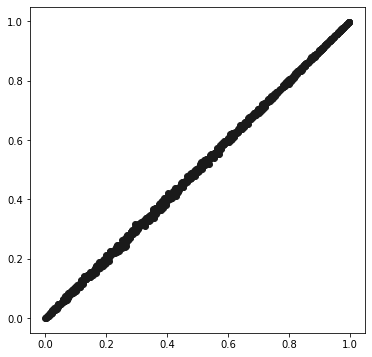

In [11]:
# Сравненим как далеки друг от друга pvalue двух критериев
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(pvalues_t, pvalues_dm, c=".1")
ax.plot([0, 1], [0, 1], ls="--", c=".1")

#### Вывод: не важно что юзать. Такую мини хитрость полезно использовать для автоматизации расчетов в airflow, чтобы не городить пары метрика+критерий. Достаточно юзать один.